<a href="https://colab.research.google.com/github/natthanich/Project_Deep_Tooth/blob/main/Regress8_Train_Unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [ ]:
import pandas as pd
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [ ]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 2850
NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 1s 0us/step


#load model


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/All_Data_Project/cut_panoramic/Model/Regression/7Re_All_1G_1e-4_16_0.2_250_New_Unfreez.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/All_Data_Project/cut_panoramic/Model/Regression/7Re_All_1G_1e-4_16_0.2_250_New_Unfreez.h5')
height = width = model.input_shape[1]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense (Dense)               (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 4,031,907
Non-trainable params: 42,016
_________________________________________

In [ ]:
df = pd.read_csv (r'/content/drive/MyDrive/All_Data_Project/cut_panoramic/Data/All_Re.csv')
df

,Fig_Age,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,7,Y07F,1,V1.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Female,Both
1,2,7,Y07F,1,Flip_V1.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Female,Both
2,3,7,Y07F,1,V2.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Female,Both
3,4,7,Y07F,1,Flip_V2.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Female,Both
4,5,7,Y07F,1,V3.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Female,Both
...,...,...,...,...,...,...,...,...
4745,121,25,Y25M,19,Flip_J463.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Male,Both
4746,122,25,Y25M,19,J464.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Male,Both
4747,123,25,Y25M,19,Flip_J464.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Male,Both
4748,124,25,Y25M,19,J465.jpg,/content/drive/My Drive/All_Data_Project/TVT_G...,Male,Both


In [ ]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [ ]:
DATA_PATH = "/content/drive/MyDrive/All_Data_Project/TVT_Gender"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/MyDrive/All_Data_Project/TVT_Gender/train
/content/drive/MyDrive/All_Data_Project/TVT_Gender/validation



#Train

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Age(year)',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Age(year)',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 2850 validated image filenames.
Found 950 validated image filenames.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense (Dense)               (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 4,031,907
Non-trainable params: 42,016
_________________________________________

In [ ]:
model.compile(loss='mse',
          optimizer=Adam(learning_rate=1e-4),
          metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-18-f59104fd3985>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
178/178 [==============================] - 753s 4s/step - loss: 0.8405 - mae: 0.5951 - val_loss: 6.4951 - val_mae: 1.8286
Epoch 2/250
178/178 [==============================] - 21s 117ms/step - loss: 0.7203 - mae: 0.5823 - val_loss: 6.8370 - val_mae: 1.8511
Epoch 3/250
178/178 [==============================] - 21s 117ms/step - loss: 0.7474 - mae: 0.6066 - val_loss: 8.0539 - val_mae: 2.0098
Epoch 4/250
178/178 [==============================] - 22s 118ms/step - loss: 0.7828 - mae: 0.6035 - val_loss: 7.3152 - val_mae: 1.8971
Epoch 5/250
178/178 [==============================] - 21s 117ms/step - loss: 0.7719 - mae: 0.6087 - val_loss: 5.1446 - val_mae: 1.6042
Epoch 6/250
178/178 [==============================] - 21s 117ms/step - loss: 0.8357 - mae: 0.6337 - val_loss: 7.0580 - val_mae: 1.8732
Epoch 7/250
178/178 [==============================] - 17s 93ms/step - loss: 0.6872 - mae: 0.5722 - val_loss: 6.8593 - val_mae: 1.8637
Epoch 8/250
178/178 [==============================

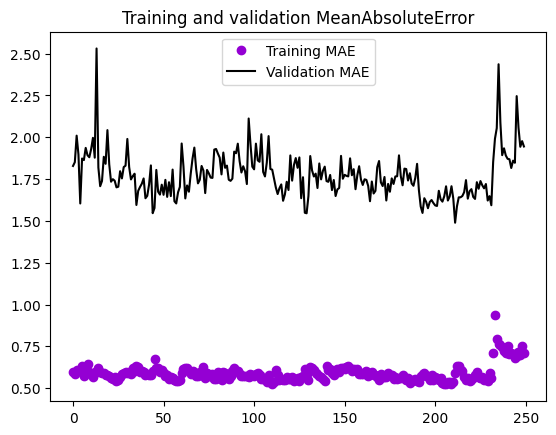

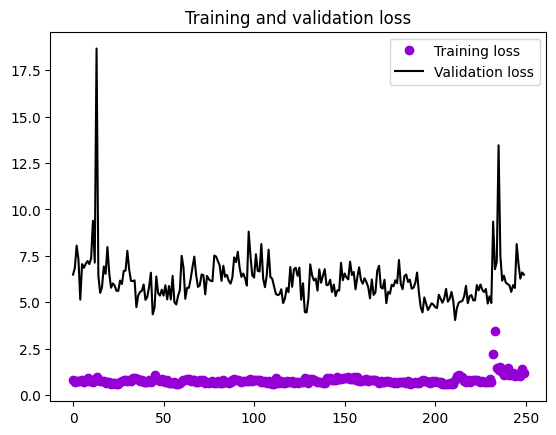

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


epochs_x = range(len(loss))


plt.plot(epochs_x, mae, 'o', color ='darkviolet', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and validation MeanAbsoluteError')
plt.legend()

plt.figure()
plt.plot(epochs_x, loss, 'o', color ='darkviolet', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
epochs_x

range(0, 250)

#Download the model


In [ ]:
os.makedirs('/content/drive/MyDrive/All_Data_Project/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/MyDrive/All_Data_Project/cut_panoramic/Model/Regression/8Re_All_1G_1e-4_16_0.2_250_New_Unfreez.h5')

In [ ]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1.1_รอบแรก_Flimpano_Male125_250.h5')